In this notebook, we will run a ready-made network starting from some ATLAS data.

In [1]:
import sys
sys.version

'3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We are going to load the cleaned dataset with [pandas](https://pandas.pydata.org/), cleaning procedure has been demonstrated [here](https://github.com/ekdnam/GSoC_HSF_ATLAS/blob/main/EDA.ipynb).

In [3]:
df = pd.read_csv('dataset/cleaned.csv')

Looking into the DataFrame

In [4]:
df

,E,pt,eta,phi
0,1069460.0,751597.0,0.858186,-1.842170
1,457647.0,110079.0,2.102870,2.175010
2,49649.1,30875.2,-1.031890,-1.799200
3,676000.0,640429.0,0.330450,0.704554
4,1239300.0,602104.0,1.343240,-0.550856
...,...,...,...,...
20360,731849.0,722541.0,-0.134499,2.563930
20361,268828.0,259144.0,0.153813,0.578428
20362,153340.0,43931.5,1.920140,-0.237382
20363,893689.0,742040.0,-0.618057,-3.104660


Importing libraries for preprocessing the data, creating the NN, training.

In [5]:
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from fastai import learner
from fastai.data import core
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler

## Normalizing the data

We are going to be using `StandardScaler` from [scikit-learn](https://scikit-learn.org/).

In [6]:
df_normalized = df.copy()
df_normalized[df_normalized.columns] = StandardScaler().fit_transform(df_normalized)

Now we will split the DataFrame into two sets, a training set, and a test set. 

Then, we will convert the values of the DataFrame into an object of TensorDataset.

In [7]:
# shuffling the data before splitting
df_normalized = shuffle(df_normalized)

# split the data into train and test with a ratio of 20%
train_x, test_x = train_test_split(df_normalized, test_size=0.2, random_state=1)

train_y = train_x  # y = x since we are building an autoencoder
test_y = test_x

print('Train data shape: ')
print(train_x.shape)
print('Test data shape: ')
print(test_x.shape)

# Constructs a tensor object of the data and wraps them in a TensorDataset object.
train_ds = TensorDataset(torch.tensor(train_x.values, dtype=torch.float), torch.tensor(train_y.values, dtype=torch.float))
valid_ds = TensorDataset(torch.tensor(test_x.values, dtype=torch.float), torch.tensor(test_y.values, dtype=torch.float))

Train data shape: 
(16292, 4)
Test data shape: 
(4073, 4)


## Creating a `DataLoader`

It will have a batch_size of 256.

In [8]:
bs = 256

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, valid_dl)

## NN architecture

Our Neural Network will have the following architecture.

In [9]:
class AE_Custom_Arch(nn.Module):
    def __init__(self, n_features=4, leakyRelu: bool = False):
        super(AE_Custom_Arch, self).__init__()
        self.en1 = nn.Linear(n_features, 128)
        self.en2 = nn.Linear(128, 64)
        self.en3 = nn.Linear(64, 32)
        self.en4 = nn.Linear(32, 3)
        self.de1 = nn.Linear(3, 32)
        self.de2 = nn.Linear(32, 64)
        self.de3 = nn.Linear(64, 128)
        self.de4 = nn.Linear(128, n_features)
        self.relu = leakyRelu
        if self.relu:
            self.leakyRelu = nn.LeakyReLU()
        else:
            self.tanh = nn.Tanh()
        
    def encode(self, x):
        if self.relu:
            return self.en4(self.leakyRelu(self.en3(self.leakyRelu(self.en2(self.leakyRelu(self.en1(x)))))))
        else:
            return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        if self.relu:
            return self.de4(self.leakyRelu(self.de3(self.leakyRelu(self.de2(self.leakyRelu(self.de1(self.leakyRelu(x))))))))
        else:
            return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

In [10]:
model = AE_Custom_Arch(leakyRelu=True)
model.to('cpu')

AE_Custom_Arch(
  (en1): Linear(in_features=4, out_features=128, bias=True)
  (en2): Linear(in_features=128, out_features=64, bias=True)
  (en3): Linear(in_features=64, out_features=32, bias=True)
  (en4): Linear(in_features=32, out_features=3, bias=True)
  (de1): Linear(in_features=3, out_features=32, bias=True)
  (de2): Linear(in_features=32, out_features=64, bias=True)
  (de3): Linear(in_features=64, out_features=128, bias=True)
  (de4): Linear(in_features=128, out_features=4, bias=True)
  (leakyRelu): LeakyReLU(negative_slope=0.01)
)

In [11]:
yhat = model(torch.tensor(train_x.values, dtype=torch.float))
yhat

tensor([[-0.0089,  0.0332,  0.0730,  0.0175],
        [-0.0089,  0.0330,  0.0732,  0.0175],
        [-0.0090,  0.0338,  0.0733,  0.0173],
        ...,
        [-0.0091,  0.0342,  0.0733,  0.0173],
        [-0.0089,  0.0335,  0.0728,  0.0175],
        [-0.0089,  0.0334,  0.0726,  0.0175]], grad_fn=<AddmmBackward>)

In [13]:
from torchviz import make_dot

make_dot(yhat, params=dict(list(model.named_parameters()))).render("torchviz", format='png')

TypeError: render() got an unexpected keyword argument 'format'

## Training the model

We now have to pick a loss function - MSE loss is appropriate for a compression autoencoder since it reflects the [(input-output)/input] physical quantity that we want to minimize.

In [11]:
from fastai.metrics import mse, partial
from fastai.callback.tracker import EarlyStoppingCallback
from fastai.test_utils import *

loss_function = nn.MSELoss()

weight_decay = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=weight_decay, loss_func=loss_function, cbs=recorder)

We want to find the best learning rate. The learning rate is a hyper-paramater that sets how much the weights of the network will change each step with respect to the loss gradient.

Then we plot the loss versus the learning rates. We're interested in finding a good order of magnitude of learning rate, so we plot with a log scale.

A good value for the learning rates is then either:

- one tenth of the minimum before the divergence
- when the slope is the steepest

Learning rate with the minimum loss: 0.012022644281387329
Learning rate with the steepest gradient: 0.010964781977236271


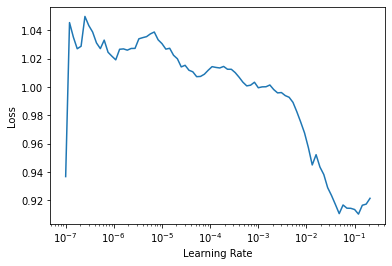

In [12]:
from fastai.callback import schedule

lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

Now we want to run the training!

User-chosen variables:

- n_epoch: The number of epochs, i.e how many times the to run through all of the training data once 
- lr: The learning rate. Either choose lr_min, lr_steep from above or set your own.

In [27]:
import time

start = time.perf_counter() # Starts timer
# train our autoencoder for 100 epochs
lr_steep = 0.033113110810518265
learn.fit_one_cycle(100, lr_steep)
end = time.perf_counter() # Ends timer
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.729760,0.600609,00:01
0,0.729760,0.600609,00:01
1,0.543652,0.412986,00:00
1,0.543652,0.412986,00:00
2,0.337760,0.226484,00:00
2,0.337760,0.226484,00:00
3,0.227063,0.174761,00:01
3,0.227063,0.174761,00:01
4,0.174404,0.144771,00:01
4,0.174404,0.144771,00:01


Training took 117.83971020000001 seconds


Then we plot the loss as a function of batches and epochs to check if we reach a plateau.

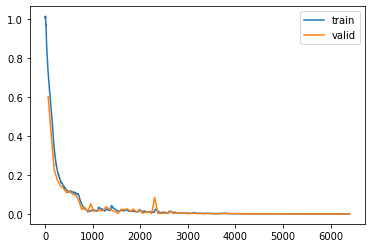

In [28]:
recorder.plot_loss()

Then we evaluate the MSE on this network - it should be of the order of 0.001 or less if all has gone well...if it has not trained as well (note the pesky 0-mass peak above...) then it's going to be a bit higher.

In [29]:
learn.validate()

(#1) [0.00013216404477134347]

## Plotting the outputs of the network

Lazy-save of our output files (they'll also be on screen)

In [30]:
import os
save_dir = "plots\AE_Custom_Arch\LeakyReLu"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

Make the histograms from the dataset.

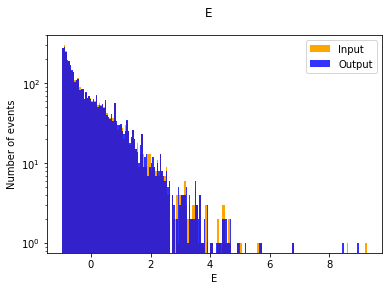

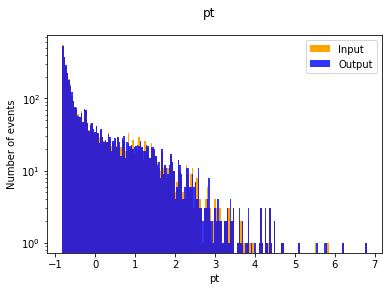

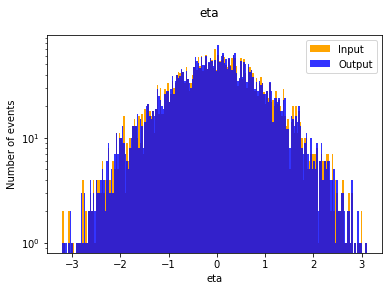

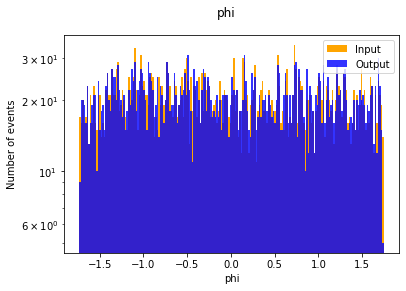

In [31]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$E$']
line_style = ['--', '-']
colors = ['blue', 'orange']
markers = ['*', 's']

model.to('cpu')

save = True # Option to save figure

# Histograms
idxs = (0, 10000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values, dtype=torch.float)

pred = model(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data, columns=test_x.columns)
pred_df = pd.DataFrame(pred, columns=test_x.columns)

alph = 0.8
n_bins = 200

for kk in np.arange(4):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(test_x.columns[kk])
    plt.xlabel(test_x.columns[kk])
    plt.ylabel('Number of events')
    # ms.sciy()
    plt.yscale('log')
    if save:
        plt.savefig(os.path.join(save_dir,test_x.columns[kk]+'.png'))
    plt.legend()